# Image Classification with Localization
#### Waleed Alabbas
This Jupyter page shows how to localize objects in images by using simple convolutional neural networks.

Finding dogs/cats (2 classes)

# Model 1: Xception

In [11]:
import csv
import math

from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import epsilon

# 0.35, 0.5, 0.75, 1.0
ALPHA = 0.35

# 96, 128, 160, 192, 224
IMAGE_SIZE = 96

EPOCHS = 10
BATCH_SIZE = 32
PATIENCE = 50

MULTI_PROCESSING = True
THREADS = 4

TRAIN_CSV = "train.csv"
VALIDATION_CSV = "validation.csv"

CLASSES = 2

class DataGenerator(Sequence):

    def __init__(self, csv_file):
        self.paths = []

        with open(csv_file, "r") as file:
            self.coords = np.zeros((sum(1 for line in file), 4 + CLASSES))
            file.seek(0)

            reader = csv.reader(file, delimiter=",")
            for index, row in enumerate(reader):
                for i, r in enumerate(row[1:7]):
                    row[i+1] = int(r)

                path, image_height, image_width, x0, y0, x1, y1, _, class_id = row
                self.coords[index, 0] = x0 * IMAGE_SIZE / image_width
                self.coords[index, 1] = y0 * IMAGE_SIZE / image_height
                self.coords[index, 2] = (x1 - x0) * IMAGE_SIZE / image_width
                self.coords[index, 3] = (y1 - y0) * IMAGE_SIZE / image_height 
                self.coords[index, min(4 + int(class_id), self.coords.shape[1]-1)] = 1

                self.paths.append(path)

    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)

    def __getitem__(self, idx):
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]

        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            img = Image.open(f)
            img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img = img.convert('RGB')

            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
            img.close()

        return batch_images, [batch_coords[...,:4], batch_coords[...,4:]]

class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs):
        mse = 0
        accuracy = 0

        intersections = 0
        unions = 0

        for i in range(len(self.generator)):
            batch_images, (gt, class_id) = self.generator[i]
            pred, pred_class = self.model.predict_on_batch(batch_images)
            mse += np.linalg.norm(gt - pred, ord='fro') / pred.shape[0]

            pred_class = np.argmax(pred_class, axis=1)
            accuracy += np.sum(np.argmax(class_id, axis=1) == pred_class)

            pred = np.maximum(pred, 0)

            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = np.maximum(diff_width, 0) * np.maximum(diff_height, 0)

            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = np.maximum(area_gt + area_pred - intersection, 0)

            intersections += np.sum(intersection * (union > 0))
            unions += np.sum(union)

        iou = np.round(intersections / (unions + epsilon()), 4)
        logs["val_iou"] = iou

        mse = np.round(mse, 4)
        logs["val_mse"] = mse

        accuracy = np.round(accuracy / len(self.generator.coords), 4)
        logs["val_acc"] = accuracy

        print(" - val_iou: {} - val_mse: {} - val_acc: {}".format(iou, mse, accuracy))


def create_model(trainable=False):
    #model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)
    model = Xception(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False)#, alpha=ALPHA)

    #InceptionV3(weights='imagenet', include_top=False)

    # to freeze layers
    for layer in model.layers:
        layer.trainable = trainable

    out = model.layers[-1].output

    x = Conv2D(4, kernel_size=3)(out)
    x = Reshape((4,), name="coords")(x)

    y = GlobalAveragePooling2D()(out)
    y = Dense(CLASSES, name="classes", activation="softmax")(y)

    return Model(inputs=model.input, outputs=[x, y])


def log_mse(y_true, y_pred):
    return tf.reduce_mean(tf.log1p(tf.squared_difference(y_pred, y_true)), axis=-1)

def focal_loss(alpha=0.9, gamma=2):
  def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
    return (tf.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

  def loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.log(y_pred / (1 - y_pred))

    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

    return tf.reduce_mean(loss)

  return loss

def main():
    model = create_model()

    train_datagen = DataGenerator(TRAIN_CSV)
    validation_datagen = Validation(generator=DataGenerator(VALIDATION_CSV))

    optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss={"coords" : log_mse, "classes" : focal_loss()}, loss_weights={"coords" : 1, "classes" : 1}, optimizer=optimizer, metrics=[])
    checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                                 save_weights_only=True, mode="max", period=1)
    stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max")
    reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

    model.summary()

    model.fit_generator(generator=train_datagen,
                        epochs=EPOCHS,
                        callbacks=[validation_datagen, checkpoint, reduce_lr, stop],
                        workers=THREADS,
                        use_multiprocessing=MULTI_PROCESSING,
                        shuffle=True,
                        verbose=1)


if __name__ == "__main__":
    main()


83689472/83683744 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 47, 47, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 47, 47, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 47, 47, 32)   0           block1_conv1_bn[0][0]            
____________________________________________

Epoch 1/10
93/94 [============================>.] - ETA: 0s - loss: 5.4543 - coords_loss: 5.4008 - classes_loss: 0.0536
 - val_iou: 0.067 - val_mse: 468.5104 - val_acc: 0.9729

Epoch 00001: val_iou improved from -inf to 0.06700, saving model to model-0.07.h5
94/94 [==============================] - 115s 1s/step - loss: 5.4516 - coords_loss: 5.3985 - classes_loss: 0.0531
Epoch 2/10
93/94 [============================>.] - ETA: 0s - loss: 5.2246 - coords_loss: 5.1765 - classes_loss: 0.0481 - val_iou: 0.0678 - val_mse: 357.5414 - val_acc: 0.9088

Epoch 00002: val_iou improved from 0.06700 to 0.06780, saving model to model-0.07.h5
94/94 [==============================] - 96s 1s/step - loss: 5.2260 - coords_loss: 5.1781 - classes_loss: 0.0479
Epoch 3/10
93/94 [============================>.] - ETA: 0s - loss: 5.1368 - coords_loss: 5.0896 - classes_loss: 0.0472 - val_iou: 0.1126 - val_mse: 384.4006 - val_acc: 0.9729

Epoch 00003: val_iou improved from 0.06780 to 0.11260, saving model to mode

#### Best result for model 1: val_iou: 0.2172 - val_mse: 288.4422 - val_acc: 0.849

# Model 2: MobileNetV2

In [15]:
import csv
import math

from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import epsilon

# 0.35, 0.5, 0.75, 1.0
ALPHA = 0.35

# 96, 128, 160, 192, 224
IMAGE_SIZE = 96

EPOCHS = 10
BATCH_SIZE = 32
PATIENCE = 50

MULTI_PROCESSING = True
THREADS = 4

TRAIN_CSV = "train.csv"
VALIDATION_CSV = "validation.csv"

CLASSES = 2

class DataGenerator(Sequence):

    def __init__(self, csv_file):
        self.paths = []

        with open(csv_file, "r") as file:
            self.coords = np.zeros((sum(1 for line in file), 4 + CLASSES))
            file.seek(0)

            reader = csv.reader(file, delimiter=",")
            for index, row in enumerate(reader):
                for i, r in enumerate(row[1:7]):
                    row[i+1] = int(r)

                path, image_height, image_width, x0, y0, x1, y1, _, class_id = row
                self.coords[index, 0] = x0 * IMAGE_SIZE / image_width
                self.coords[index, 1] = y0 * IMAGE_SIZE / image_height
                self.coords[index, 2] = (x1 - x0) * IMAGE_SIZE / image_width
                self.coords[index, 3] = (y1 - y0) * IMAGE_SIZE / image_height 
                self.coords[index, min(4 + int(class_id), self.coords.shape[1]-1)] = 1

                self.paths.append(path)

    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)

    def __getitem__(self, idx):
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]

        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            img = Image.open(f)
            img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img = img.convert('RGB')

            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
            img.close()

        return batch_images, [batch_coords[...,:4], batch_coords[...,4:]]

class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs):
        mse = 0
        accuracy = 0

        intersections = 0
        unions = 0

        for i in range(len(self.generator)):
            batch_images, (gt, class_id) = self.generator[i]
            pred, pred_class = self.model.predict_on_batch(batch_images)
            mse += np.linalg.norm(gt - pred, ord='fro') / pred.shape[0]

            pred_class = np.argmax(pred_class, axis=1)
            accuracy += np.sum(np.argmax(class_id, axis=1) == pred_class)

            pred = np.maximum(pred, 0)

            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = np.maximum(diff_width, 0) * np.maximum(diff_height, 0)

            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = np.maximum(area_gt + area_pred - intersection, 0)

            intersections += np.sum(intersection * (union > 0))
            unions += np.sum(union)

        iou = np.round(intersections / (unions + epsilon()), 4)
        logs["val_iou"] = iou

        mse = np.round(mse, 4)
        logs["val_mse"] = mse

        accuracy = np.round(accuracy / len(self.generator.coords), 4)
        logs["val_acc"] = accuracy

        print(" - val_iou: {} - val_mse: {} - val_acc: {}".format(iou, mse, accuracy))


def create_model(trainable=False):
    model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)

    # to freeze layers
    for layer in model.layers:
        layer.trainable = trainable

    out = model.layers[-1].output

    x = Conv2D(4, kernel_size=3)(out)
    x = Reshape((4,), name="coords")(x)

    y = GlobalAveragePooling2D()(out)
    y = Dense(CLASSES, name="classes", activation="softmax")(y)

    return Model(inputs=model.input, outputs=[x, y])


def log_mse(y_true, y_pred):
    return tf.reduce_mean(tf.log1p(tf.squared_difference(y_pred, y_true)), axis=-1)

def focal_loss(alpha=0.9, gamma=2):
  def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
    return (tf.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

  def loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.log(y_pred / (1 - y_pred))

    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

    return tf.reduce_mean(loss)

  return loss

def main():
    model = create_model()

    train_datagen = DataGenerator(TRAIN_CSV)
    validation_datagen = Validation(generator=DataGenerator(VALIDATION_CSV))

    optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss={"coords" : log_mse, "classes" : focal_loss()}, loss_weights={"coords" : 1, "classes" : 1}, optimizer=optimizer, metrics=[])
    checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                                 save_weights_only=True, mode="max", period=1)
    stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max")
    reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

    model.summary()

    model.fit_generator(generator=train_datagen,
                        epochs=EPOCHS,
                        callbacks=[validation_datagen, checkpoint, reduce_lr, stop],
                        workers=THREADS,
                        use_multiprocessing=MULTI_PROCESSING,
                        shuffle=True,
                        verbose=1)


if __name__ == "__main__":
    main()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 16)   432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 16)   64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

Epoch 1/10
93/94 [============================>.] - ETA: 0s - loss: 4.1744 - coords_loss: 4.1043 - classes_loss: 0.0701Epoch 1/10
 - val_iou: 0.4545 - val_mse: 93.8821 - val_acc: 0.9729

Epoch 00001: val_iou improved from -inf to 0.45450, saving model to model-0.45.h5
94/94 [==============================] - 70s 741ms/step - loss: 4.1690 - coords_loss: 4.0996 - classes_loss: 0.0694
Epoch 2/10
93/94 [============================>.] - ETA: 0s - loss: 3.6094 - coords_loss: 3.5565 - classes_loss: 0.0528 - val_iou: 0.4909 - val_mse: 95.7263 - val_acc: 0.9701

Epoch 00002: val_iou improved from 0.45450 to 0.49090, saving model to model-0.49.h5
94/94 [==============================] - 17s 181ms/step - loss: 3.6068 - coords_loss: 3.5546 - classes_loss: 0.0523
Epoch 3/10
93/94 [============================>.] - ETA: 0s - loss: 3.3549 - coords_loss: 3.3105 - classes_loss: 0.0443 - val_iou: 0.4873 - val_mse: 94.0023 - val_acc: 0.9729

Epoch 00003: val_iou did not improve from 0.49090
94/94 [=====

#### Best result for model 2: val_iou: 0.5117 - val_mse: 87.7904 - val_acc: 0.9729

# Model 3: VGG16

In [16]:
import csv
import math

from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
#from tensorflow.keras.applications.mobilenet_v1 import MobileNetV1, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import epsilon

# 0.35, 0.5, 0.75, 1.0
ALPHA = 0.35

# 96, 128, 160, 192, 224
IMAGE_SIZE = 96

EPOCHS = 10
BATCH_SIZE = 32
PATIENCE = 50

MULTI_PROCESSING = True
THREADS = 4

TRAIN_CSV = "train.csv"
VALIDATION_CSV = "validation.csv"

CLASSES = 2

class DataGenerator(Sequence):

    def __init__(self, csv_file):
        self.paths = []

        with open(csv_file, "r") as file:
            self.coords = np.zeros((sum(1 for line in file), 4 + CLASSES))
            file.seek(0)

            reader = csv.reader(file, delimiter=",")
            for index, row in enumerate(reader):
                for i, r in enumerate(row[1:7]):
                    row[i+1] = int(r)

                path, image_height, image_width, x0, y0, x1, y1, _, class_id = row
                self.coords[index, 0] = x0 * IMAGE_SIZE / image_width
                self.coords[index, 1] = y0 * IMAGE_SIZE / image_height
                self.coords[index, 2] = (x1 - x0) * IMAGE_SIZE / image_width
                self.coords[index, 3] = (y1 - y0) * IMAGE_SIZE / image_height 
                self.coords[index, min(4 + int(class_id), self.coords.shape[1]-1)] = 1

                self.paths.append(path)

    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)

    def __getitem__(self, idx):
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]

        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            img = Image.open(f)
            img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img = img.convert('RGB')

            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
            img.close()

        return batch_images, [batch_coords[...,:4], batch_coords[...,4:]]

class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs):
        mse = 0
        accuracy = 0

        intersections = 0
        unions = 0

        for i in range(len(self.generator)):
            batch_images, (gt, class_id) = self.generator[i]
            pred, pred_class = self.model.predict_on_batch(batch_images)
            mse += np.linalg.norm(gt - pred, ord='fro') / pred.shape[0]

            pred_class = np.argmax(pred_class, axis=1)
            accuracy += np.sum(np.argmax(class_id, axis=1) == pred_class)

            pred = np.maximum(pred, 0)

            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = np.maximum(diff_width, 0) * np.maximum(diff_height, 0)

            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = np.maximum(area_gt + area_pred - intersection, 0)

            intersections += np.sum(intersection * (union > 0))
            unions += np.sum(union)

        iou = np.round(intersections / (unions + epsilon()), 4)
        logs["val_iou"] = iou

        mse = np.round(mse, 4)
        logs["val_mse"] = mse

        accuracy = np.round(accuracy / len(self.generator.coords), 4)
        logs["val_acc"] = accuracy

        print(" - val_iou: {} - val_mse: {} - val_acc: {}".format(iou, mse, accuracy))


def create_model(trainable=False):
    #model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)
    model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False)#, alpha=ALPHA)

    #InceptionV3(weights='imagenet', include_top=False)

    # to freeze layers
    for layer in model.layers:
        layer.trainable = trainable

    out = model.layers[-1].output

    x = Conv2D(4, kernel_size=3)(out)
    x = Reshape((4,), name="coords")(x)

    y = GlobalAveragePooling2D()(out)
    y = Dense(CLASSES, name="classes", activation="softmax")(y)

    return Model(inputs=model.input, outputs=[x, y])


def log_mse(y_true, y_pred):
    return tf.reduce_mean(tf.log1p(tf.squared_difference(y_pred, y_true)), axis=-1)

def focal_loss(alpha=0.9, gamma=2):
  def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
    return (tf.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

  def loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.log(y_pred / (1 - y_pred))

    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

    return tf.reduce_mean(loss)

  return loss

def main():
    model = create_model()

    train_datagen = DataGenerator(TRAIN_CSV)
    validation_datagen = Validation(generator=DataGenerator(VALIDATION_CSV))

    optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss={"coords" : log_mse, "classes" : focal_loss()}, loss_weights={"coords" : 1, "classes" : 1}, optimizer=optimizer, metrics=[])
    checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                                 save_weights_only=True, mode="max", period=1)
    stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max")
    reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

    model.summary()

    model.fit_generator(generator=train_datagen,
                        epochs=EPOCHS,
                        callbacks=[validation_datagen, checkpoint, reduce_lr, stop],
                        workers=THREADS,
                        use_multiprocessing=MULTI_PROCESSING,
                        shuffle=True,
                        verbose=1)


if __name__ == "__main__":
    main()


58892288/58889256 [==============================] - 1s 0us/stepTA
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 96, 96, 64)   1792        input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 96, 96, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 48, 48, 64)   0           block1_conv2[0][0]               
__________________________________________

#### Best result for model 3: val_iou: 0.1878 - val_mse: 225.8725 - val_acc: 0.9729

Result Table


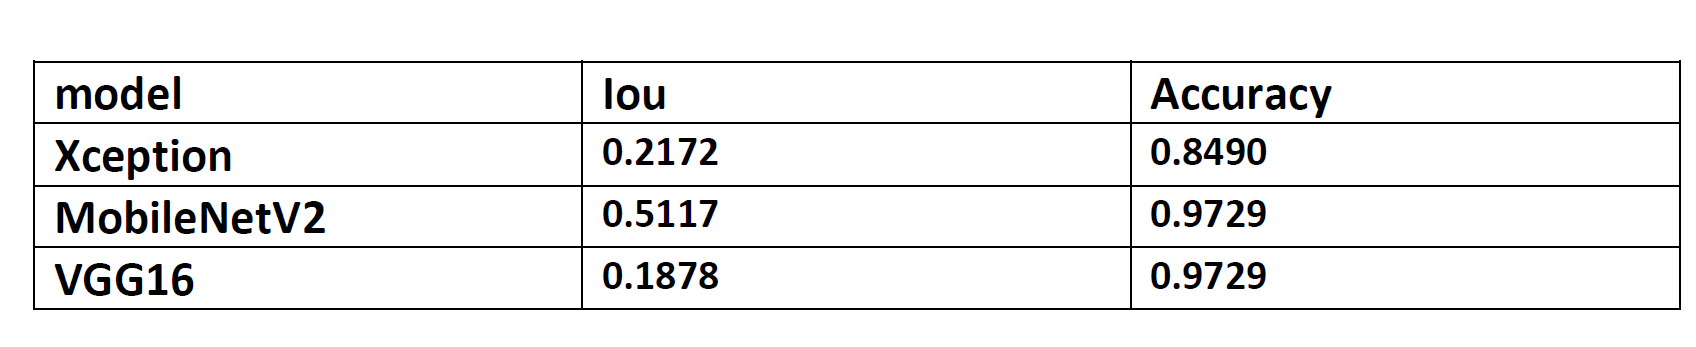

In [18]:
from IPython.display import Image
print("Result Table")
Image("1111.png")